In [2]:
# importando libs
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
from datetime import datetime
from datetime import timedelta
import yfinance as yf
import pickle
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
from prophet import plot
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/home/fabricio/Documentos/Projetos/tcc_predict_crypto/model_predict/.predict/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

import plotly.graph_objs as go

In [42]:
DAYS_PREDICT = 15

In [7]:
date_today = datetime.today().strftime("%Y-%m-%d")
data_init = "2014-01-01"

df_btc = yf.download("BTC-USD", data_init, date_today)

df_btc.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [70]:
df_btc.reset_index(inplace=True)
df_btc.tail()

,index,Date,Open,High,Low,Close,Adj Close,Volume
2922,2922,2022-09-17,19777.033203,20162.531250,19777.033203,20127.576172,20127.576172,24957448100
2923,2923,2022-09-18,20127.234375,20127.234375,19387.492188,19419.505859,19419.505859,31254779144
2924,2924,2022-09-19,19418.572266,19639.480469,18390.318359,19544.128906,19544.128906,40177002624
2925,2925,2022-09-20,19545.591797,19602.457031,18813.455078,18890.789062,18890.789062,36791346508
2926,2926,2022-09-21,18891.283203,19674.630859,18290.314453,18547.400391,18547.400391,46363793975


In [71]:

fig = go.Figure()

fig.add_trace(go.Candlestick(x=df_btc.Date,
                open=df_btc['Open'],
                high=df_btc['High'],
                low=df_btc['Low'],
                close=df_btc['Close'], 
                name = 'Datas Bitcoin'))


,Date,Open,High,Low,Close,Adj Close,Volume
2922,2022-09-17,19777.033203,20162.531250,19777.033203,20127.576172,20127.576172,24957448100
2923,2022-09-18,20127.234375,20127.234375,19387.492188,19419.505859,19419.505859,31254779144
2924,2022-09-19,19418.572266,19639.480469,18390.318359,19544.128906,19544.128906,40177002624
2925,2022-09-20,19545.591797,19602.457031,18813.455078,18890.789062,18890.789062,36791346508
2926,2022-09-21,18891.283203,19674.630859,18290.314453,18547.400391,18547.400391,46363793975


In [10]:
df = df_btc[["Date", "Close"]]
df.rename(columns= { "Date": "ds", "Close": "y" }, inplace=True)

In [11]:
df.tail()

,ds,y
2922,2022-09-17,20127.576172
2923,2022-09-18,19419.505859
2924,2022-09-19,19544.128906
2925,2022-09-20,18890.789062
2926,2022-09-21,18547.400391


In [12]:
df.isnull().sum().sum()
df['ds'].isnull().sum()
df['y'].isnull().sum()

0

In [13]:
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [14]:
model = Prophet(interval_width=0.95)
model.fit(df)

23:55:18 - cmdstanpy - INFO - Chain [1] start processing
23:55:20 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
model = Prophet(
    	# growth = "linear",
    	# interval_width=0.8, 
        # changepoint_range=0.5, # treino
		# yearly_seasonality=False,
		# weekly_seasonality=False, 
		# daily_seasonality=False, 
		# holidays=None,
		seasonality_mode='multiplicative',
  		# changepoint_prior_scale=0.001,
    	# changepoints=['2021-11-10']
)
model.fit(df)

00:23:07 - cmdstanpy - INFO - Chain [1] start processing
00:23:09 - cmdstanpy - INFO - Chain [1] done processing


In [87]:
future = model.make_future_dataframe(periods=5, freq='D', include_history=False)
future.tail()

,ds
0,2022-09-22
1,2022-09-23
2,2022-09-24
3,2022-09-25
4,2022-09-26


In [88]:
# predict 
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2022-09-22,30088.103861,24733.507168,31545.099287,30088.103861,30088.103861,-0.067340,-0.067340,-0.067340,-0.001372,-0.001372,-0.001372,-0.065968,-0.065968,-0.065968,0.0,0.0,0.0,28061.977691
1,2022-09-23,30047.324199,25039.345079,31523.416010,30047.324199,30047.324199,-0.058800,-0.058800,-0.058800,-0.000477,-0.000477,-0.000477,-0.058323,-0.058323,-0.058323,0.0,0.0,0.0,28280.538509
2,2022-09-24,30006.544538,25410.817178,31462.192346,30006.544538,30006.544538,-0.049108,-0.049108,-0.049108,0.000423,0.000423,0.000423,-0.049531,-0.049531,-0.049531,0.0,0.0,0.0,28532.974933
3,2022-09-25,29965.764876,25780.135291,31973.643763,29965.764876,29965.764876,-0.039084,-0.039084,-0.039084,0.000508,0.000508,0.000508,-0.039592,-0.039592,-0.039592,0.0,0.0,0.0,28794.569675
4,2022-09-26,29924.985215,25934.186604,32553.344138,29924.985215,29924.985215,-0.027757,-0.027757,-0.027757,0.000761,0.000761,0.000761,-0.028518,-0.028518,-0.028518,0.0,0.0,0.0,29094.356823


In [89]:
forecast[["ds", "yhat_lower", "yhat_upper", "yhat"]].tail(2)

,ds,yhat_lower,yhat_upper,yhat
3,2022-09-25,25780.135291,31973.643763,28794.569675
4,2022-09-26,25934.186604,32553.344138,29094.356823


In [38]:
# Default change points
print(f'There are {len(model.changepoints)} change points. \nThe change points dates are \n{df.loc[df["ds"].isin(model.changepoints)]}')

There are 25 change points. 
The change points dates are 
             ds             y
99   2014-12-25    319.007996
199  2015-04-04    253.697006
298  2015-07-12    310.867004
398  2015-10-20    269.463013
497  2016-01-27    394.971985
597  2016-05-06    459.602997
696  2016-08-13    585.588013
796  2016-11-21    739.247986
895  2017-02-28   1179.969971
994  2017-06-07   2732.159912
1094 2017-09-15   3637.520020
1193 2017-12-23  14699.200195
1293 2018-04-02   7083.799805
1392 2018-07-10   6329.950195
1492 2018-10-18   6476.709961
1591 2019-01-25   3599.765869
1690 2019-05-04   5831.167480
1790 2019-08-12  11382.616211
1889 2019-11-19   8206.145508
1989 2020-02-27   8784.494141
2088 2020-06-05   9665.533203
2188 2020-09-13  10323.755859
2287 2020-12-21  22803.082031
2387 2021-03-31  58918.832031
2486 2021-07-08  32877.371094


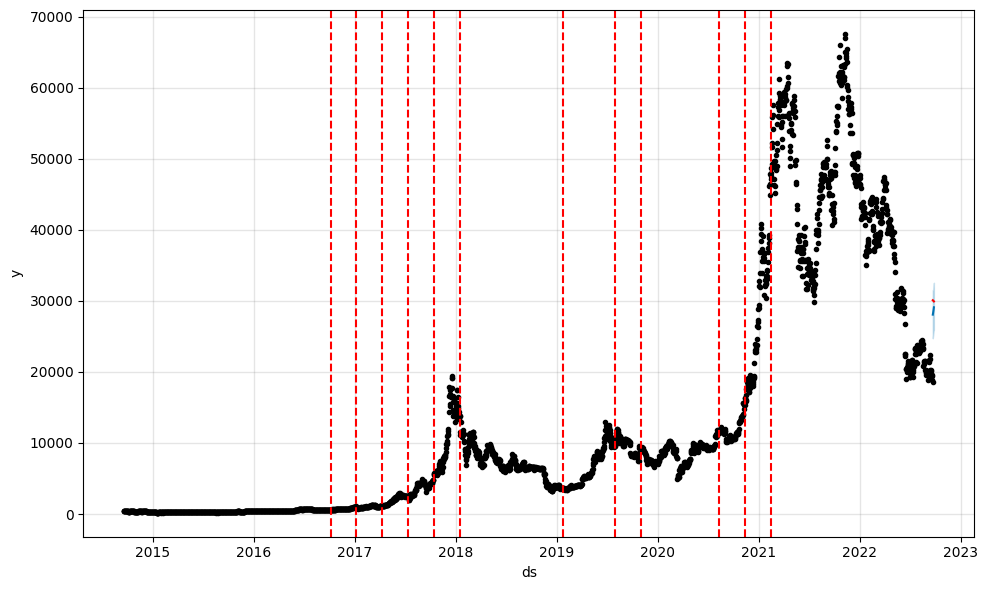

In [90]:
# Change points to plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [110]:
# Cross validation
df_cv = cross_validation(model, initial='365 days', period='30 days', horizon = '15 days', parallel="processes")
df_cv.tail()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:16 - cmdstanpy - INFO - Chain [1] start processing
22:19:16 - cmdstanpy - INFO - Chain [1] start processing
22:19:16 - cmdstanpy - INFO - Chain [1] done processing
22:19:17 - cmdstanpy - INFO - Chain [1] done processing
22:19:17 - cmdstanpy - INFO - Chain [1] done processing
22:19:19 - cmdstanpy - INFO - Chain [1] done processing
22:19:19 - cmdstanpy - INFO - Chain [1] start processing
22:19:19 - cmdstanpy - INFO - Chain [1] start processing
22:19:20 - cmdstanpy - INFO - Chain [1] start processing
22:19:21 - cmdstanpy - INFO - Chain [1] done 

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
1270,2022-09-16,31961.606237,28469.693335,35351.494152,19772.583984,2022-09-05
1271,2022-09-17,31993.036842,28402.329254,35513.151619,20127.576172,2022-09-05
1272,2022-09-18,32003.102253,28462.956446,35190.177273,19419.505859,2022-09-05
1273,2022-09-19,32026.329397,28411.512572,35455.994679,19544.128906,2022-09-05
1274,2022-09-20,32066.090163,28575.646208,35464.014825,18890.789062,2022-09-05


In [119]:
# Model performance metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
9,11 days,1.522576e+08,12339.269801,5659.293791,0.274519,0.154638,0.242287,0.254933
10,12 days,1.629900e+08,12766.751793,5824.837059,0.289279,0.168751,0.254078,0.235201
11,13 days,1.788367e+08,13372.983271,6141.792789,0.310568,0.187890,0.269430,0.184159
12,14 days,1.927010e+08,13881.677334,6360.672979,0.317713,0.186266,0.275340,0.172580
13,15 days,2.055264e+08,14336.191298,6639.121938,0.327760,0.201272,0.284757,0.168597


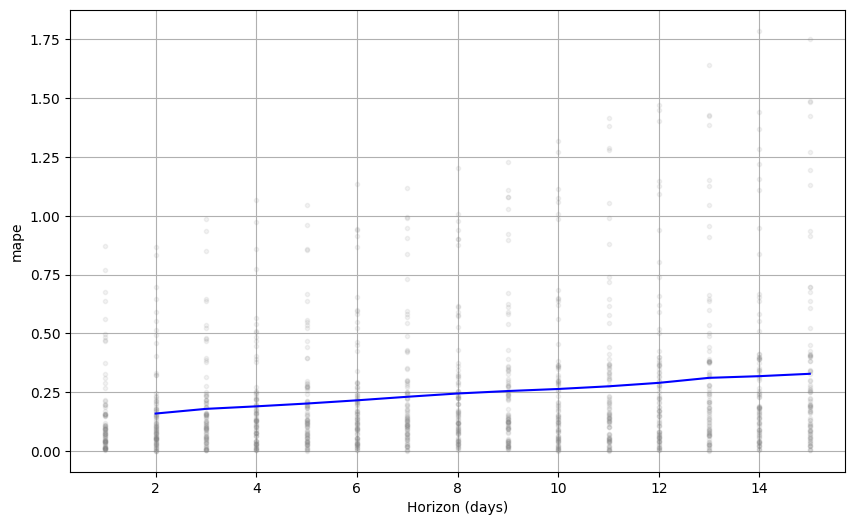

In [120]:
# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [33]:
# Salvar modelo
with open('model_btc_usd.pckl', 'wb') as fout:
    pickle.dump(model, fout)

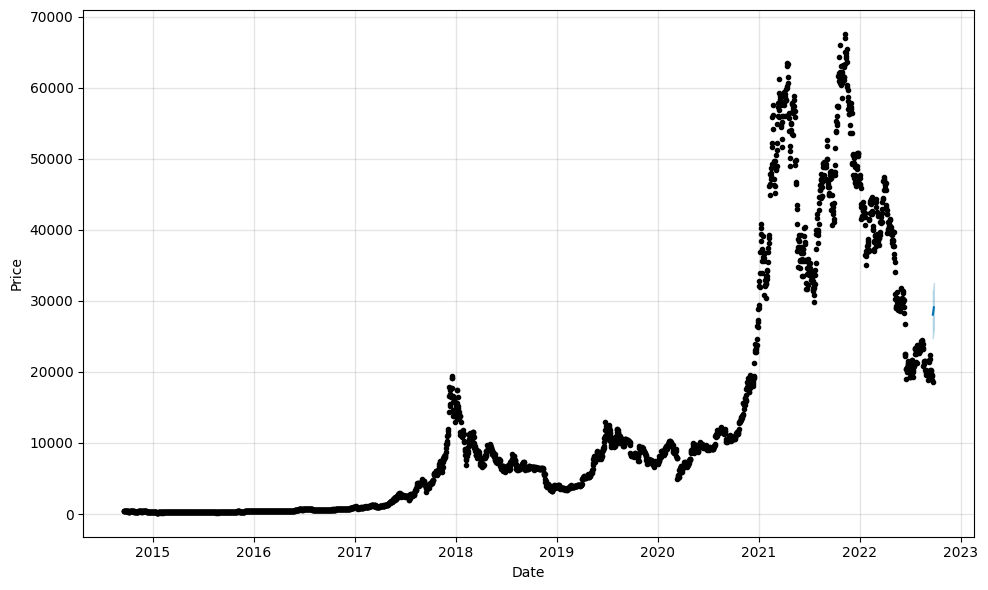

In [91]:
figure_1 = model.plot(forecast,
                    xlabel='Date',
                    ylabel='Price')

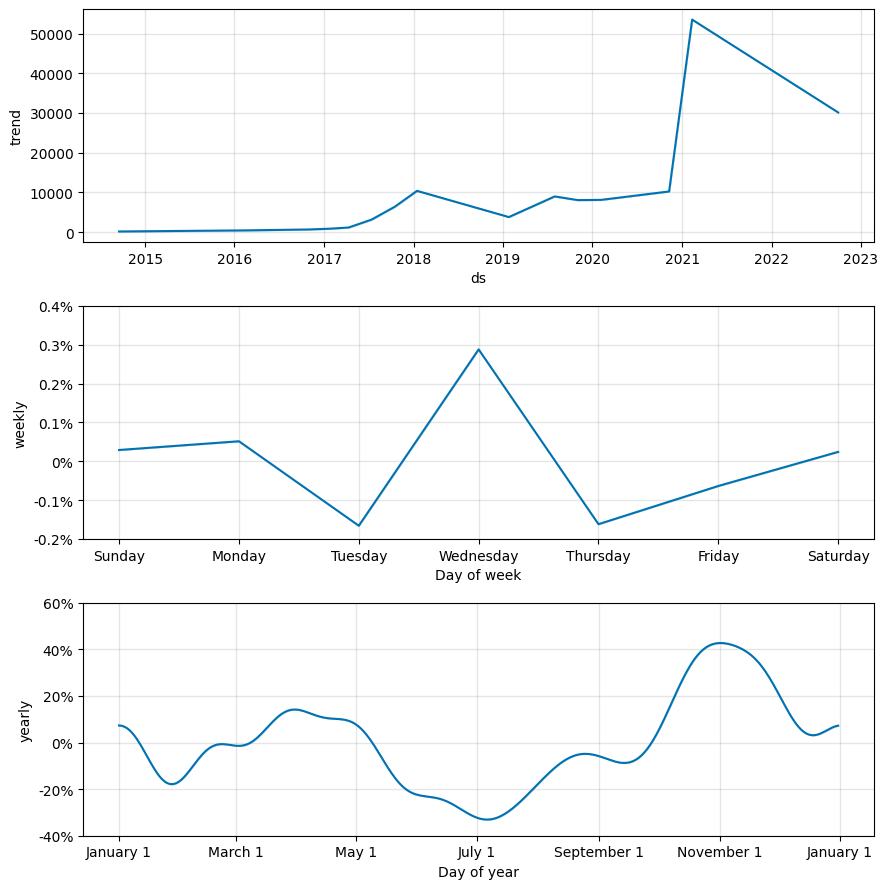

In [138]:
figure_2 = model.plot_components(forecast)
